In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset from previous step
df = pd.read_csv("../../data/processed/train_dataset_formatted_no_missing.csv")
df.head()

,longitude,latitude,label,gravity_iso_residual,gravity_cscba,gravity_cscba_1vd,gravity_iso_residual_stddev3x3,gravity_cscba_stddev3x3,mag_uc_1_2km,mag_uc_2_4km,...,mag_uc_12_16km,mag_uc_2_4km_1vd,mag_uc_2_4km_thd,mag_uc_2_4km_stddev3x3,radio_k_pct,radio_th_ppm,radio_u_ppm,radio_th_k_ratio,radio_u_k_ratio,radio_u_th_ratio
0,145.277695,-34.107134,0,52.223591,349.392853,-40.59006,0.752113,37.011612,0.584576,0.992970,...,1.204403,-0.000780,0.001489,0.038044,1.104598,10.030174,1.367533,9.082856,1.238717,0.136452
1,125.714108,-23.943929,0,-195.990967,-534.088440,-556.97266,2.474874,47.704494,3.931087,5.403521,...,-0.071080,-0.013591,0.021547,0.549094,0.158148,15.495625,1.302552,77.478119,6.512759,0.084177
2,148.821727,-21.846854,1,376.498871,-531.526184,198.01955,0.918559,46.138040,-15.808146,0.000513,...,-2.160016,-0.091868,0.096375,2.462595,0.327474,3.212502,0.507891,9.933004,1.592497,0.159617
3,134.851273,-19.145144,0,10.045643,-709.562378,-201.86922,1.362985,60.546470,-12.336065,-17.813541,...,-10.113371,0.025990,0.028927,0.738085,0.281605,7.375026,0.806524,26.118765,2.877724,0.111031
4,142.587968,-28.984738,0,-34.105846,114.804726,-124.66106,2.218750,87.284930,-2.577452,-4.013026,...,-2.264580,-0.006811,0.014678,0.374207,0.442369,3.287470,0.641557,7.432631,1.465061,0.198236


## 1. Identify Skewed Features with Potential Outliers

In [58]:
# Calculate skewness for each feature
skewed = df.drop(columns=['label', 'longitude', 'latitude']).skew().sort_values(ascending=False)

# Display most skewed features
skewed_features = skewed[abs(skewed) > 1]
print("Skewed features (|skew| > 1):")
display(skewed_features)

Skewed features (|skew| > 1):


gravity_iso_residual_stddev3x3    70.085329
radio_u_th_ratio                  11.197971
gravity_cscba_stddev3x3            5.465078
radio_th_k_ratio                   5.012672
radio_u_k_ratio                    3.697955
mag_uc_2_4km_thd                   3.475682
mag_uc_2_4km_stddev3x3             3.461542
radio_th_ppm                       3.206813
mag_uc_1_2km                       3.113130
radio_u_ppm                        2.802171
mag_uc_2_4km                       2.346362
radio_k_pct                        1.760271
mag_uc_4_8km                       1.713546
mag_uc_8_12km                      1.544065
mag_uc_12_16km                     1.417283
gravity_cscba_1vd                 -1.080492
mag_uc_2_4km_1vd                  -1.330059
dtype: float64

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import skew

def identify_log1p_candidates(df, skew_threshold=1.0, exclude_cols=None):
    """
    Identifies features in a DataFrame suitable for log1p transformation.

    Args:
        df (pd.DataFrame): The input DataFrame.
        skew_threshold (float): The minimum positive skewness value to consider
                                 a feature as a candidate. Defaults to 1.0 (highly skewed).
                                 Can be lowered (e.g., 0.75 or 0.5) for moderate skew.
        exclude_cols (list, optional): A list of column names to exclude from
                                       the analysis (e.g., IDs, target variable,
                                       coordinates). Defaults to None.

    Returns:
        tuple: A tuple containing:
            - list: Column names that are good candidates for log1p
                    (non-negative values and positive skew > threshold).
            - list: Column names with potential issues (e.g., contain negative
                    values, or have negative skew but user might want to check).
    """
    if exclude_cols is None:
        exclude_cols = []

    good_candidates = []
    potential_issues = []
    numeric_cols = df.select_dtypes(include=np.number).columns

    print(f"--- Analyzing Numeric Columns for log1p Transformation (Skewness Threshold > {skew_threshold}) ---")

    for col in numeric_cols:
        if col in exclude_cols:
            print(f"Skipping excluded column: '{col}'")
            continue

        # Check for missing values (log1p cannot handle NaN directly)
        if df[col].isnull().any():
            print(f"WARNING: Column '{col}' contains missing values. Handle them before transformation.")
            potential_issues.append(f"{col} (has NaNs)")
            continue # Skip further checks for this column

        # Check minimum value
        min_val = df[col].min()

        # Calculate skewness
        # Ensure the column has variance before calculating skewness
        if df[col].nunique() <= 1 or df[col].var() == 0:
             skewness = 0 # No variance, no skewness essentially
             print(f"Column '{col}': Min = {min_val:.4f}, Skewness = N/A (Constant Value or No Variance)")
        else:
            try:
                # Using scipy's skew which allows specifying bias correction if needed
                # Default bias=True matches pandas behavior for sample skewness
                skewness = skew(df[col].dropna()) # dropna just in case, though we checked above
            except Exception as e:
                print(f"ERROR calculating skewness for column '{col}': {e}")
                potential_issues.append(f"{col} (skewness error)")
                continue


        print(f"Column '{col}': Min = {min_val:.4f}, Skewness = {skewness:.4f}")

        # --- Decision Logic ---
        if min_val < 0:
            # log1p cannot be directly applied meaningfully to negative values
            # even if > -1, as it's intended for non-negative data skewness.
            print(f"  -> Issue: Contains negative values (min={min_val:.4f}). Not a direct candidate for log1p unless shifted.")
            potential_issues.append(f"{col} (negative values)")
        elif skewness > skew_threshold:
             # Non-negative and high positive skewness
             print(f"  -> Candidate: Non-negative and positive skew > {skew_threshold}.")
             good_candidates.append(col)
        elif skewness < -skew_threshold:
             # High negative skew - log1p is inappropriate
             print(f"  -> Issue: Highly negatively skewed ({skewness:.4f}). log1p is inappropriate.")
             potential_issues.append(f"{col} (negative skew)")
        else:
             # Low skew or moderate negative skew
             print(f"  -> Not a candidate: Skewness ({skewness:.4f}) not above threshold {skew_threshold}.")


    print("\n--- Summary ---")
    print(f"Good candidates for log1p (Non-negative, Skewness > {skew_threshold}):")
    if good_candidates:
        for col in good_candidates:
            print(f"- {col}")
    else:
        print("None")

    print(f"\nColumns with potential issues (Negative values, Negative skew, NaNs, Errors):")
    if potential_issues:
         for issue in potential_issues:
             print(f"- {issue}")
    else:
        print("None")

    return good_candidates, potential_issues



In [4]:
# Define columns to exclude (adjust as needed)
# Typically includes location, identifiers, and the target variable if present
exclude = ['longitude', 'latitude', 'label'] 


# Identify candidates with skewness > 1.0
log1p_candidates, issues = identify_log1p_candidates(df, skew_threshold=1.0, exclude_cols=exclude)

# --- Applying the transformation (after identification) ---
if log1p_candidates:
    print("\nApplying log1p transformation to candidates...")
    for col in log1p_candidates:
        df[f'{col}_log1p'] = np.log1p(df[col])
        print(f"  - Created '{col}_log1p'")

--- Analyzing Numeric Columns for log1p Transformation (Skewness Threshold > 1.0) ---
Skipping excluded column: 'longitude'
Skipping excluded column: 'latitude'
Skipping excluded column: 'label'
Column 'gravity_iso_residual': Min = -1194.7560, Skewness = -0.7090
  -> Issue: Contains negative values (min=-1194.7560). Not a direct candidate for log1p unless shifted.
Column 'gravity_cscba': Min = -7671.6387, Skewness = -0.0681
  -> Issue: Contains negative values (min=-7671.6387). Not a direct candidate for log1p unless shifted.
Column 'gravity_cscba_1vd': Min = -1561.3601, Skewness = -1.0802
  -> Issue: Contains negative values (min=-1561.3601). Not a direct candidate for log1p unless shifted.
Column 'gravity_iso_residual_stddev3x3': Min = 0.0000, Skewness = 70.0640
  -> Candidate: Non-negative and positive skew > 1.0.
Column 'gravity_cscba_stddev3x3': Min = 0.0000, Skewness = 5.4634
  -> Candidate: Non-negative and positive skew > 1.0.
Column 'mag_uc_1_2km': Min = -173.1307, Skewness = 

In [5]:
from scipy.stats import skew
log_skewed_result = {
    col + "_log1p": skew(df[col + "_log1p"].dropna())
    for col in log1p_candidates if col + "_log1p" in df.columns
}
log_skew_df = pd.DataFrame.from_dict(log_skewed_result, orient='index', columns=["Skewness_after_log"])
log_skew_df = log_skew_df.sort_values("Skewness_after_log", ascending=False)

log_skew_df

,Skewness_after_log
radio_u_th_ratio_log1p,5.606443
mag_uc_2_4km_thd_log1p,2.869593
gravity_iso_residual_stddev3x3_log1p,1.388631
mag_uc_2_4km_stddev3x3_log1p,1.331782
radio_th_k_ratio_log1p,0.857317
radio_u_k_ratio_log1p,0.774853
gravity_cscba_stddev3x3_log1p,0.024457


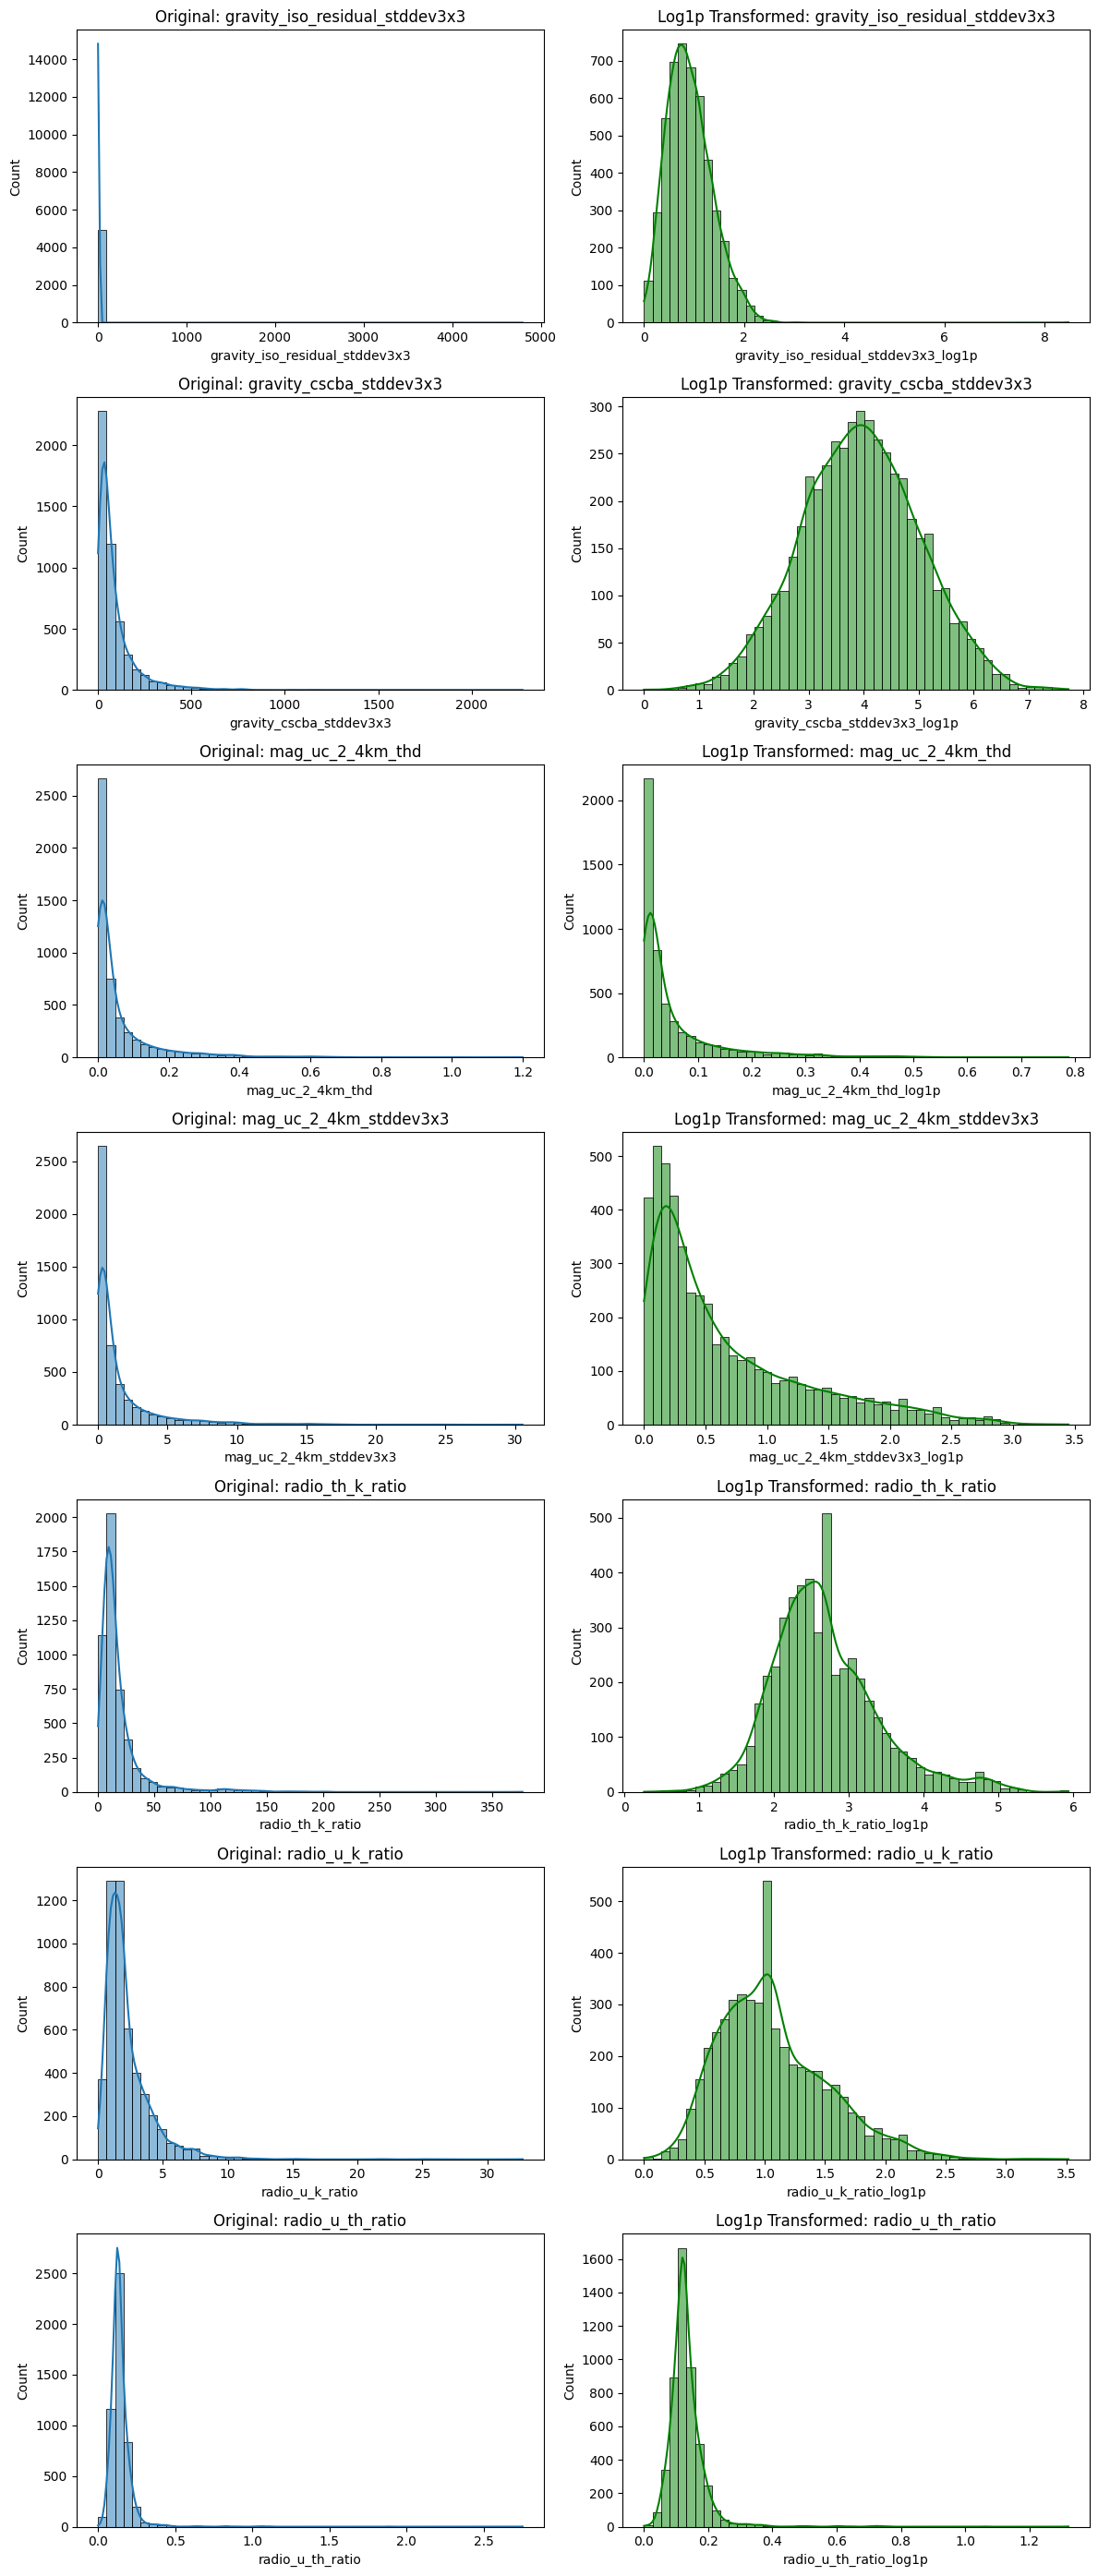

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(len(log1p_candidates), 2, figsize=(12, 4 * len(log1p_candidates)))

# Visualizing log transform effect
for i, col in enumerate(log1p_candidates):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i][0])
    axes[i][0].set_title(f"Original: {col}")
    
    sns.histplot(df[f"{col}_log1p"], bins=50, kde=True, ax=axes[i][1], color="green")
    axes[i][1].set_title(f"Log1p Transformed: {col}")
    
plt.tight_layout()
plt.show()


In [6]:
log1p_candidates

['gravity_iso_residual_stddev3x3',
 'gravity_cscba_stddev3x3',
 'mag_uc_2_4km_thd',
 'mag_uc_2_4km_stddev3x3',
 'radio_th_k_ratio',
 'radio_u_k_ratio',
 'radio_u_th_ratio']

In [7]:
df.columns

Index(['longitude', 'latitude', 'label', 'gravity_iso_residual',
       'gravity_cscba', 'gravity_cscba_1vd', 'gravity_iso_residual_stddev3x3',
       'gravity_cscba_stddev3x3', 'mag_uc_1_2km', 'mag_uc_2_4km',
       'mag_uc_4_8km', 'mag_uc_8_12km', 'mag_uc_12_16km', 'mag_uc_2_4km_1vd',
       'mag_uc_2_4km_thd', 'mag_uc_2_4km_stddev3x3', 'radio_k_pct',
       'radio_th_ppm', 'radio_u_ppm', 'radio_th_k_ratio', 'radio_u_k_ratio',
       'radio_u_th_ratio', 'gravity_iso_residual_stddev3x3_log1p',
       'gravity_cscba_stddev3x3_log1p', 'mag_uc_2_4km_thd_log1p',
       'mag_uc_2_4km_stddev3x3_log1p', 'radio_th_k_ratio_log1p',
       'radio_u_k_ratio_log1p', 'radio_u_th_ratio_log1p'],
      dtype='object')

In [8]:
df.drop(columns=log1p_candidates, inplace=True, errors='ignore')
# errors='ignore' prevents error if a column was already dropped or didn't exist

print(f"Dropped original columns: {log1p_candidates}")
print("DataFrame now contains transformed columns instead.")

Dropped original columns: ['gravity_iso_residual_stddev3x3', 'gravity_cscba_stddev3x3', 'mag_uc_2_4km_thd', 'mag_uc_2_4km_stddev3x3', 'radio_th_k_ratio', 'radio_u_k_ratio', 'radio_u_th_ratio']
DataFrame now contains transformed columns instead.


In [66]:
df.columns

Index(['longitude', 'latitude', 'label', 'gravity_iso_residual',
       'gravity_cscba', 'gravity_cscba_1vd', 'mag_uc_1_2km', 'mag_uc_2_4km',
       'mag_uc_4_8km', 'mag_uc_8_12km', 'mag_uc_12_16km', 'mag_uc_2_4km_1vd',
       'radio_k_pct', 'radio_th_ppm', 'radio_u_ppm',
       'gravity_iso_residual_stddev3x3_log1p', 'gravity_cscba_stddev3x3_log1p',
       'mag_uc_2_4km_thd_log1p', 'mag_uc_2_4km_stddev3x3_log1p',
       'radio_th_k_ratio_log1p', 'radio_u_k_ratio_log1p',
       'radio_u_th_ratio_log1p'],
      dtype='object')

In [10]:
df.to_csv("../../data/processed/train_dataset_log1p_transformed.csv", index=False)
print("Saved to: train_dataset_log1p_transformed.csv")

Saved to: train_dataset_log1p_transformed.csv


## 3. Outlier Handling Summary

Several features in the dataset exhibit strong right-skewed distributions and extreme values (e.g., `radio_Th_K_ratio`, `radio_U_K_ratio`, `mag_uc_*`). To mitigate their influence on model performance:

- We applied **log1p transformation** to reduce skewness while retaining continuous variation.
- Optionally, we **clipped** values above the 99th percentile to limit extreme impact.
- Transformed versions of these features are retained as new columns (`*_log` or `*_clipped`) for further selection and modeling.